**Universidade Federal de Minas Gerais**  
**Departamento de Ciência da Computação**  
**Aprendizado de Máquina**  
**Valéria Pereira de Souza**    

## Trabalho Prático 1 - Classificação de Exoplanetas

# Apresentação do problema

Um KOI - Kepler Object of Interest é uma corpo celeste que se suspeita ser um exoplaneta. A partir da observação de diversas características, o corpo é classificado como KOI e posteriormente, após novas verificações é feita a classificação dos KOI em "Confirmado" ou "Falso positivo". O problema deste trabalho prático se trata de classificar automaticamente se um KOI é um exoplaneta confirmado ou um falso positivo.

Para tanto, iremos utilizar uma série de algoritmos classificadores a serem treinados em dados anotados. Os desempenhos serão aferidos pela métrica acurácia e posteriormente comparados para identificação do melhor resultado.

## 1. Inspeção, limpeza e preparação dos dados

In [15]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import minmax_scale
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import KFold
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix

In [2]:
INPUT_FILEPATH = "koi_data.csv"
TARGET = "koi_disposition"
N_FOLDS = 5

Vamos carregar os dados e olhar algumas instâncias

In [4]:
data_raw = pd.read_csv(INPUT_FILEPATH)
data_raw.head(5)

,kepoi_name,koi_disposition,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
0,K00752.01,CONFIRMED,9.48804,0.146,2.95750,615.8,0.02234,3.20796,2.26,0.0853,...,0.430,0.940,-0.00020,-0.00055,-0.010,0.200,0.200,0.080,0.310,0.320
1,K00752.02,CONFIRMED,54.41838,0.586,4.50700,874.8,0.02795,3.02368,2.83,0.2734,...,-0.630,1.230,0.00066,-0.00105,0.390,0.000,0.390,0.490,0.120,0.500
2,K00754.01,FALSE POSITIVE,1.73695,1.276,2.40641,8079.2,0.38739,0.22080,33.46,0.0267,...,-0.111,0.002,0.00302,-0.00142,-0.249,0.147,0.289,-0.257,0.099,0.276
3,K00755.01,CONFIRMED,2.52559,0.701,1.65450,603.3,0.02406,1.98635,2.75,0.0374,...,-0.010,0.230,0.00008,-0.00007,0.030,-0.090,0.100,0.070,0.020,0.070
4,K00114.01,FALSE POSITIVE,7.36179,1.169,5.02200,233.7,0.18339,0.00485,39.21,0.0820,...,-13.450,24.090,0.00303,-0.00555,-4.506,7.710,8.930,-4.537,7.713,8.948


Observarmos 43 colunas, das quais uma se refere ao código de cada KOI e outra se refere à anotação do dado de interesse (y). As demais colunas parecem ser nuéricas. Vamos investigar essa informação

In [5]:
data_raw.dtypes

kepoi_name           object
koi_disposition      object
koi_period          float64
koi_impact          float64
koi_duration        float64
koi_depth           float64
koi_ror             float64
koi_srho            float64
koi_prad            float64
koi_sma             float64
koi_incl            float64
koi_teq             float64
koi_insol           float64
koi_dor             float64
koi_max_sngle_ev    float64
koi_max_mult_ev     float64
koi_model_snr       float64
koi_steff           float64
koi_slogg           float64
koi_smet            float64
koi_srad            float64
koi_smass           float64
koi_kepmag          float64
koi_gmag            float64
koi_rmag            float64
koi_imag            float64
koi_zmag            float64
koi_jmag            float64
koi_hmag            float64
koi_kmag            float64
koi_fwm_stat_sig    float64
koi_fwm_sra         float64
koi_fwm_sdec        float64
koi_fwm_srao        float64
koi_fwm_sdeco       float64
koi_fwm_prao        

De fato, todas as demais colunas são numéricas e do mesmo tipo; não haverá necessidade de tranaformações de features categóricas A coluna kepoi_name traz indentificadores únicos para cada instância. Dessa forma, não é uma feature discriminativa entre as classes e, portanto, será desconsiderada, bem como separaremos a coluna de anotação das dados.  

y conterá as respostas  
X conterá um DataFrame com todas as features originais

In [6]:
y = data_raw[TARGET]
X = data_raw.drop(columns=['kepoi_name', 'koi_disposition'])

Vamos investigar as features e verificar quais transformações serão necessárias

In [7]:
X.isnull().values.any()

False

In [8]:
X.describe()

,koi_period,koi_impact,koi_duration,koi_depth,koi_ror,koi_srho,koi_prad,koi_sma,koi_incl,koi_teq,...,koi_fwm_srao,koi_fwm_sdeco,koi_fwm_prao,koi_fwm_pdeco,koi_dicco_mra,koi_dicco_mdec,koi_dicco_msky,koi_dikco_mra,koi_dikco_mdec,koi_dikco_msky
count,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,...,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000
mean,37.032237,0.717106,5.607025,21340.318993,0.235205,3.415370,112.230798,0.158146,81.181413,1143.721069,...,-0.355681,-0.805629,-0.000263,0.000439,-0.049743,-0.087413,1.930251,-0.038402,-0.098738,1.920226
std,88.417985,2.628207,6.962634,66989.808550,2.586213,25.131368,3699.799318,0.241792,16.308839,775.788868,...,10.978677,14.741473,0.065707,0.077519,2.465670,2.746534,3.147553,2.465094,2.734732,3.142764
min,0.306940,0.000000,0.104600,0.800000,0.001290,0.000040,0.080000,0.007200,2.290000,92.000000,...,-275.600000,-397.620000,-4.000000,-0.800000,-21.500000,-75.900000,0.000000,-23.600000,-76.600000,0.000000
25%,2.213962,0.226000,2.500250,176.800000,0.013058,0.176092,1.460000,0.033000,81.930000,615.250000,...,-0.500000,-0.570000,-0.000240,-0.000240,-0.270000,-0.291500,0.128250,-0.265250,-0.320000,0.180000
50%,7.386755,0.610000,3.805500,495.950000,0.024185,0.748045,2.600000,0.073650,87.890000,948.000000,...,0.000000,-0.030000,0.000000,0.000000,0.000000,0.000000,0.460000,-0.007000,-0.018000,0.453000
75%,23.448117,0.923750,6.000750,2120.525000,0.171260,2.267063,21.645000,0.158200,89.520000,1482.000000,...,0.500000,0.450000,0.000260,0.000280,0.230000,0.230000,2.570000,0.226250,0.250000,2.420000
max,1071.232620,100.806000,138.540000,864260.000000,99.870650,918.752390,200346.000000,2.034500,90.000000,9791.000000,...,97.780000,98.780000,1.190000,5.000000,45.680000,27.500000,88.600000,46.570000,31.200000,89.600000


Não existem valores faltantes.
Mas observarmos que existe grande variância na escala de valores das features. Esse fato pode representar um problema para algoritmos paramétricos uma vez que features com valores mais extremos influenciarão mais o resultado enviesando artificalmente os modelos. Para evitar esse tipo de problema, faremos um procedimento de feature scaling pela técnica de normalização no intervalo (0, 1)

In [9]:
# Normalização das features
X = pd.DataFrame(minmax_scale(X, feature_range=(0, 1)))
X.describe()

,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
count,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,...,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000,5202.000000
mean,0.034293,0.007114,0.039747,0.024691,0.002342,0.003717,0.000560,0.074457,0.899457,0.108436,...,0.737169,0.799384,0.770662,0.138007,0.319295,0.733197,0.021786,0.335779,0.709659,0.021431
std,0.082562,0.026072,0.050295,0.077511,0.025896,0.027354,0.018467,0.119268,0.185940,0.079986,...,0.029403,0.029697,0.012660,0.013365,0.036702,0.026562,0.035525,0.035130,0.025369,0.035075
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.001781,0.002242,0.017305,0.000204,0.000118,0.000192,0.000007,0.012726,0.907992,0.053949,...,0.736783,0.799859,0.770667,0.137890,0.316017,0.731223,0.001448,0.332546,0.707607,0.002009
50%,0.006611,0.006051,0.026734,0.000573,0.000229,0.000814,0.000013,0.032778,0.975943,0.088257,...,0.738122,0.800947,0.770713,0.137931,0.320036,0.734043,0.005192,0.336226,0.710408,0.005056
75%,0.021609,0.009164,0.042591,0.002453,0.001702,0.002468,0.000108,0.074483,0.994527,0.143314,...,0.739461,0.801914,0.770763,0.137979,0.323459,0.736267,0.029007,0.339550,0.712894,0.027009
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Por último, faremos o encoding dos labels

In [10]:
label_encoder = LabelEncoder()
label_encoder.fit(['CONFIRMED', 'FALSE POSITIVE'])
y = label_encoder.transform(y)

## 2. Experimentos

#### *Classe utilitária*

In [12]:
class Experiment():
    def __init__(self):

        self.X_train, self.X_test = [], []
        self.y_train, self.y_test = [], []
        self.train_index, self.test_index = [], []
        self.train_pred, self.test_pred = [], []
        
        self.accuracy_train, self.accuracy_test = [], []
        self.precision_train, self.precision_test = [], []
        self.recall_train, self.recall_test = [], []
        self.mean_train_accuracy = 0
        self.mean_test_accuracy = 0
        self.mean_train_precision = 0
        self.mean_test_precision = 0
        self.mean_train_recall = 0
        self.mean_test_recall = 0

    def run_decision_tree(self, depth):
        for self.train_index, self.test_index in self.get_folds():

            self.slice_fold()            

            clf = DecisionTreeClassifier(max_depth=depth)
            clf = clf.fit(self.X_train, self.y_train)

            self.get_predictions(clf)
            self.get_metrics_per_fold()
            
        self.get_mean_metrics()
        
    def run_naive_bayes(self):
        for self.train_index, self.test_index in self.get_folds():

            self.slice_fold()            

            clf = GaussianNB()
            clf = clf.fit(self.X_train, self.y_train)

            self.get_predictions(clf)
            self.get_metrics_per_fold()
            
        self.get_mean_metrics()
    
    def get_folds(self):
        kfold = KFold(N_FOLDS, True, 1)
        return kfold.split(X)
    
    def slice_fold(self):
        global X
        global y
        self.X_train = X.iloc[self.train_index]
        self.y_train = y[self.train_index]
        
        self.X_test = X.iloc[self.test_index]
        self.y_test = y[self.test_index]
        
        
    def get_predictions(self, clf):
        self.train_pred = clf.predict(self.X_train)
        self.test_pred = clf.predict(self.X_test)
        
    def get_metrics_per_fold(self):
        self.accuracy_train.append(accuracy_score(self.y_train, self.train_pred))
        self.accuracy_test.append(accuracy_score(self.y_test, self.test_pred))
        
        self.precision_train.append(precision_score(self.y_train, self.train_pred))
        self.precision_test.append(precision_score(self.y_test, self.test_pred))
        
        self.recall_train.append(recall_score(self.y_train, self.train_pred))
        self.recall_test.append(recall_score(self.y_test, self.test_pred))
    
    def get_mean_metrics(self):
        self.mean_train_accuracy = np.mean(self.accuracy_train)
        self.mean_test_accuracy = np.mean(self.accuracy_test)

        self.mean_train_precision = np.mean(self.precision_train)
        self.mean_test_precision = np.mean(self.precision_test)

        self.mean_train_recall = np.mean(self.recall_train)
        self.mean_test_recall = np.mean(self.recall_test)
    
    def print_results(self):
        print("Train accuracy: ", self.mean_train_accuracy)
        print("Test accuracy:", self.mean_test_accuracy)
        print("Train precision: ", self.mean_train_precision)
        print("Test precision: ", self.mean_test_precision)
        print("Train recall: ", self.mean_train_recall)
        print("Test recall: ", self.mean_test_recall)
    
    def plot_folds(self):
        #line graph - all metrics X hiperparâmetro variado



In [28]:
# Estruturas auxiliares
accuracy_train, precision_train, recall_train = [], [], []
accuracy_test, precision_test, recall_test = [], [], []

In [37]:
def save_results(objeto):
    """ 
    Função auxiliar que salva resultados de muitos experimentos
    """
    global accuracy_train
    global precision_train
    global recall_train
    global accuracy_test
    global precision_test
    global recall_test
    
    accuracy_train.append(objeto.mean_train_accuracy)
    accuracy_test.append(objeto.mean_test_accuracy)
    
    precision_train.append(objeto.mean_train_precision)
    precision_test.append(objeto.mean_test_precision)
  
    recall_train.append(objeto.mean_train_recall)
    recall_test.append(objeto.mean_test_recall)

### 2. Baseline

O algoritmo Naive Bayes, no qual é calculada a probabilidade condicional de cada feature dado o rótulo observado.

In [13]:
baseline = Experiment()
baseline.run_naive_bayes()
baseline.print_results()

Train accuracy:  0.91685910714593
Test accuracy: 0.9175338062513856
Train precision:  0.9799221525989648
Test precision:  0.9795733517273257
Train recall:  0.8784121666027411
Test recall:  0.8799206286043619


## 3. Modelos

### 3.1 Decision Trees

Decision Tree é um classificador não paramétrico baseado na escolha de features que minimizem a entropia do subconjunto


[Variar a altura máxima da árvore (incluindo permitir altura ilimitada) e mostrar os resultados graficamente]


###### 3.1.1 Experimentos

3.1.1.1 *Altura: ilimitada*

In [18]:
# árvore de tamanho ilimitado
no_prunning = Experiment()
no_prunning.run_decision_tree(None)
no_prunning.print_results()

Train accuracy:  1.0
Test accuracy: 0.9482888125323286
Train precision:  1.0
Test precision:  0.958580671619049
Train recall:  1.0
Test recall:  0.9545112412148047


*3.1.1.2 Altura: variando de 1 a 30*

In [52]:
accuracy_train, precision_train, recall_train = [], [], []
accuracy_test, precision_test, recall_test = [], [], []

decision_tree = Experiment()

for i in tqdm(range(1, 30+1)):
    decision_tree.run_decision_tree(i)
    save_results(decision_tree)


100%|██████████| 30/30 [00:28<00:00,  1.24s/it]


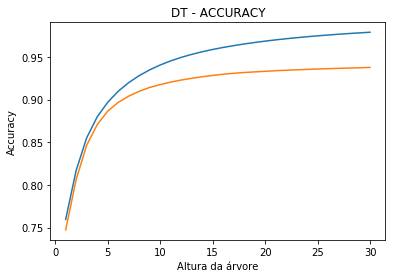

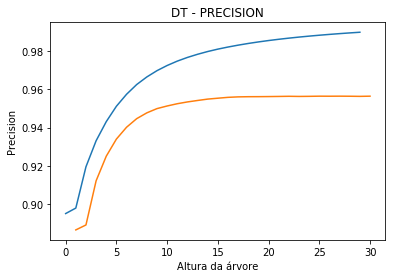

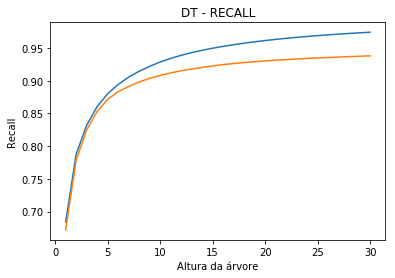

In [62]:
#plotar resultados pela acurária
x = [i for i in range(1, 30+1) ]

plt.subplot()
plt.title('DT - ACCURACY')
plt.xlabel('Altura da árvore')
plt.ylabel('Accuracy')
plt.plot(accuracy_train, label = 'treino')
plt.plot(accuracy_test, label = 'teste')
plt.show()

plt.subplot()
plt.title('DT - PRECISION')
plt.xlabel('Altura da árvore')
plt.ylabel('Precision')
plt.plot(precision_train, label = 'treino')
plt.plot(precision_test, label = 'teste')
plt.show()

plt.subplot()
plt.title('DT - RECALL')
plt.xlabel('Altura da árvore')
plt.ylabel('Recall')
plt.plot(recall_train, label = 'treino')
plt.plot(recall_test, label = 'teste')
plt.show()

### 3.2 SVM

### 3.3 kNN

### 3.4 Random Forest

### 3.5 Gradient Tree Boosting